In [1]:
import os
import shutil
import glob
import SimpleITK as sitk
import six
import radiomics
import getopt
import sys
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from radiomics import featureextractor, getTestCase
import pydicom
import pydicom_seg
import SimpleITK as sitk
import ast
import json
import pandas
import seaborn as sns
# importing the zipfile module
from zipfile import ZipFile
from sklearn.model_selection import KFold ,StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
import statistics
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
from scipy.stats import f

from zipfile import ZipFile
BASE_PATH = "/data4/hrehman/Clinical_Data/"

# BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
# INPUT_FOLDER = 'data4/Clinical Data/3-13-2023/'
INPUT_FOLDER = BASE_PATH + '3-13-2023/'
# INPUT_FOLDER_zipped = BASE_PATH_zipped
# patients_zipped = os.listdir(INPUT_FOLDER_zipped)
# patients_zipped.sort()
segmentaion_dict = {}

Comparison of brain test images from github with the data we have and see if everything is ok

# Feature Extraction:

At this point we dont have to work with the conversion of the data anymore , we already have the relavent CT and the segmentation with us. Reading patinets data and try to extract the features

In [2]:
patients = os.listdir(INPUT_FOLDER)
patients.sort()
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [3]:
#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()
params = './params.yml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)
features = {}

for patient in patients:
    if str(patient+'.txt') in config_patinets:
        path = BASE_PATH + "Nifti/" + patient
        print(patient)
        image = sitk.ReadImage(path + "/CT/"+patient+"_clean.nii")
        mask = sitk.ReadImage(path + "/SEG/"+patient+"_clean.nii")
        # image = sitk.Cast(image,sitk.sitkInt16)
        # mask = sitk.Cast(mask,sitk.sitkInt16)
        # Since the origin and the physical space issue is encountred, we will set them same for both of the images
        # get physical info for image
        spacing = image.GetSpacing()
        direction = image.GetDirection()
        origin = image.GetOrigin()
        # set physical info
        mask.SetSpacing(spacing)
        mask.SetOrigin(origin)
        mask.SetDirection(direction)
        features[patient] = extractor.execute( image, mask)

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133


In [6]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

dumped = json.dumps(features, cls=NumpyEncoder)

with open(BASE_PATH + "Nifti/features.json", 'w') as f:
    json.dump(dumped, f)

In [7]:
with open(BASE_PATH + "Nifti/features.json", 'r') as f:
    data_read = json.load(f)

In [8]:
# A list of the valid features from any case id, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features.get('R01-003'))))

In [9]:
len(patients)

137

In [10]:
# Make a numpy array of all the values
import numpy as np
count = 0
samples = np.zeros((len(config_patinets),len(feature_names)))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        samples[count,:] = a
        count +=1
# May have NaNs
samples = np.nan_to_num(samples)

Now that we have all the features from all the patients from available dataset of 5 ids, we will use the above feature names and perform scaling

# Multidimensional scaling:

Multidimensional scaling or MDS is as way to visualize very high dimensional data in a lower dimensional space. In our case, the feature space is len(feature_names) (or 93) dimensional space. To help us understand the data, we project into 2d space. MDS preserves the relative distance between sample points during the projection, so two samples close together in 2d space would also be close together in the original 93-dimensional space (and vice versa).

We us non-metric algorithm, because our data are highly non uniform in the scale of each feature.

In [11]:
#With no metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos_MDS = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [12]:
#With metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=True)
pos_PCA = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


# Plot

Here we use the results. NB: there are two points in the "green-ish" colored circle in the center of the plot.

Looking over our features, it's likely that meningioma and astrocytoma could be distinguisted by a classifier (based on our rather limited data set), but, in at least one case, glioma and astrocytoma features are relatively close together.

In [13]:
clinicalData = pandas.read_csv("/data4/hrehman/Clinical_Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
clinicalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Case ID                                            211 non-null    object 
 1   Patient affiliation                                211 non-null    object 
 2   Age at Histological Diagnosis                      211 non-null    int64  
 3   Weight (lbs)                                       211 non-null    object 
 4   Gender                                             211 non-null    object 
 5   Ethnicity                                          211 non-null    object 
 6   Smoking status                                     211 non-null    object 
 7   Pack Years                                         163 non-null    object 
 8   Quit Smoking Year                                  108 non-null    float64
 9   %GG       

In [14]:
histrology  = clinicalData[['Histology ','Case ID']]
histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)
histrology  = histrology[histrology['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
histrology = histrology[histrology['Case ID'].isin(ids)]
histrology['uid'] = np.arange(len(config_patinets))
histrology.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Histology  137 non-null    object
 1   Case ID    137 non-null    object
 2   uid        137 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


/tmp/ipykernel_4065353/2304738963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)


In [15]:
histrology.head()

,Histology,Case ID,uid
49,Adenocarcinoma,R01-001,0
50,Adenocarcinoma,R01-002,1
51,Adenocarcinoma,R01-003,2
52,Squamous cell carcinoma,R01-004,3
53,Adenocarcinoma,R01-005,4


In [18]:
from sklearn.preprocessing import LabelEncoder
survival_status = clinicalData[['Survival Status','Case ID']]
survival_status  = survival_status[survival_status['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
survival_status = survival_status[survival_status['Case ID'].isin(ids)]
survival_status['uid'] = np.arange(len(config_patinets))
# creating instance of labelencoder
labelencoder = LabelEncoder()
survival_status['labels']  = labelencoder.fit_transform(survival_status['Survival Status'])
survival_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survival Status  137 non-null    object
 1   Case ID          137 non-null    object
 2   uid              137 non-null    int64 
 3   labels           137 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


In [24]:
survival_status.tail(5)

,Survival Status,Case ID,uid,labels
189,Alive,R01-141,132,0
190,Alive,R01-142,133,0
192,Alive,R01-144,134,0
193,Alive,R01-145,135,0
194,Dead,R01-146,136,1


# With Type of Tumor

with MDS

/tmp/ipykernel_4065353/3555333915.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


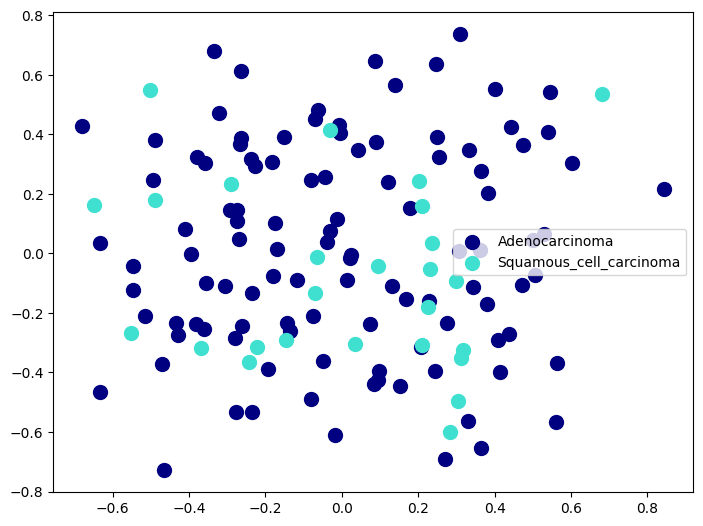

In [21]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import pandas as pd

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_MDS[Adenocarcinoma, 0], pos_MDS[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_MDS[Squamous_cell_carcinoma, 0], pos_MDS[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

/tmp/ipykernel_4065353/460703106.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


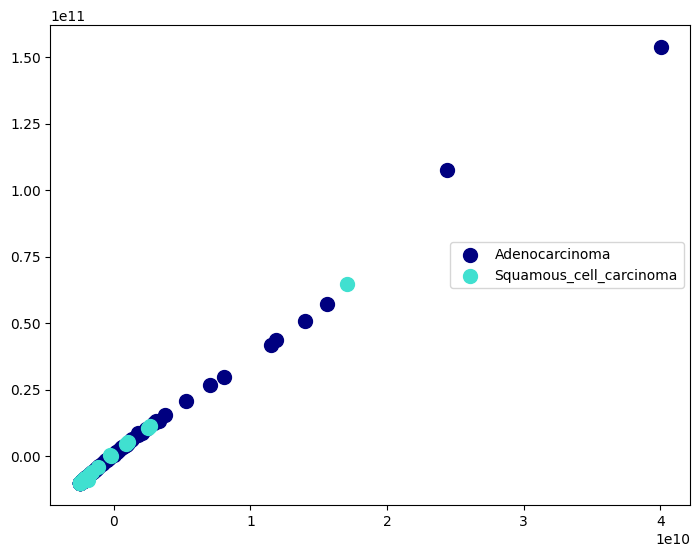

In [22]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_PCA[Adenocarcinoma, 0], pos_PCA[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_PCA[Squamous_cell_carcinoma, 0], pos_PCA[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

# With Type of Survial Status

/tmp/ipykernel_4065353/822239636.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


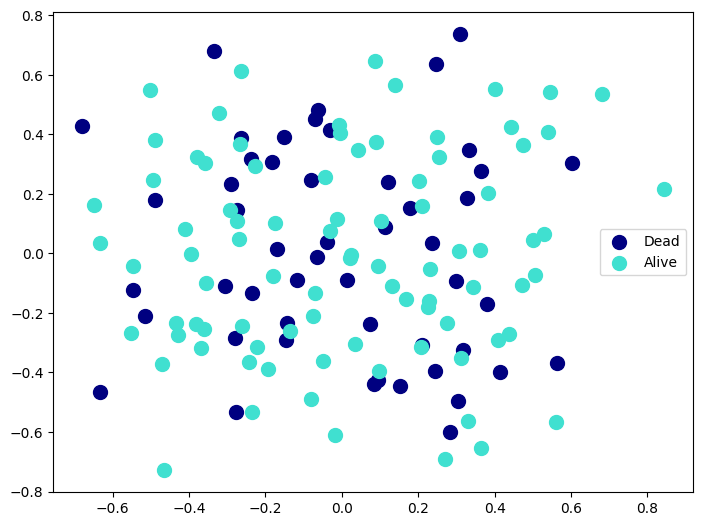

In [23]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_MDS[dead, 0], pos_MDS[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_MDS[alive, 0], pos_MDS[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

/tmp/ipykernel_4065353/983176487.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


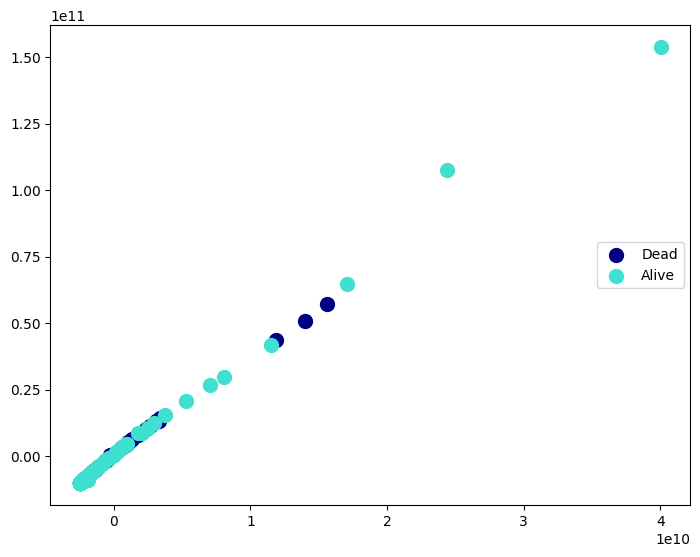

In [25]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_PCA[dead, 0], pos_PCA[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_PCA[alive, 0], pos_PCA[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

# Plot features as a heatmap

In [21]:
# data_labels = pd.read_csv("/data4/hrehman/Clinical Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
# data_labels = data_labels['']
# types = np.array(csv['Histology'])

In [22]:
# import pandas as pd
# import seaborn as sns

# # type of each tumor
# types =['meningioma', 'meningioma', 'meningioma', 'glioma', 'astrocytoma', 'glioma', 'astrocytoma', 'astrocytoma', 'astrocytoma', 'glioma']
# types = 

# # Construct a pandas dataframe from the samples
# d = pd.DataFrame(data=samples, columns=feature_names, index=types)

# corr = d.corr()

# # Set up the matplotlib figure, make it big!
# f, ax = plt.subplots(figsize=(15, 10))

# # Draw the heatmap using seaborn
# sns.heatmap(corr, vmax=.8, square=True)

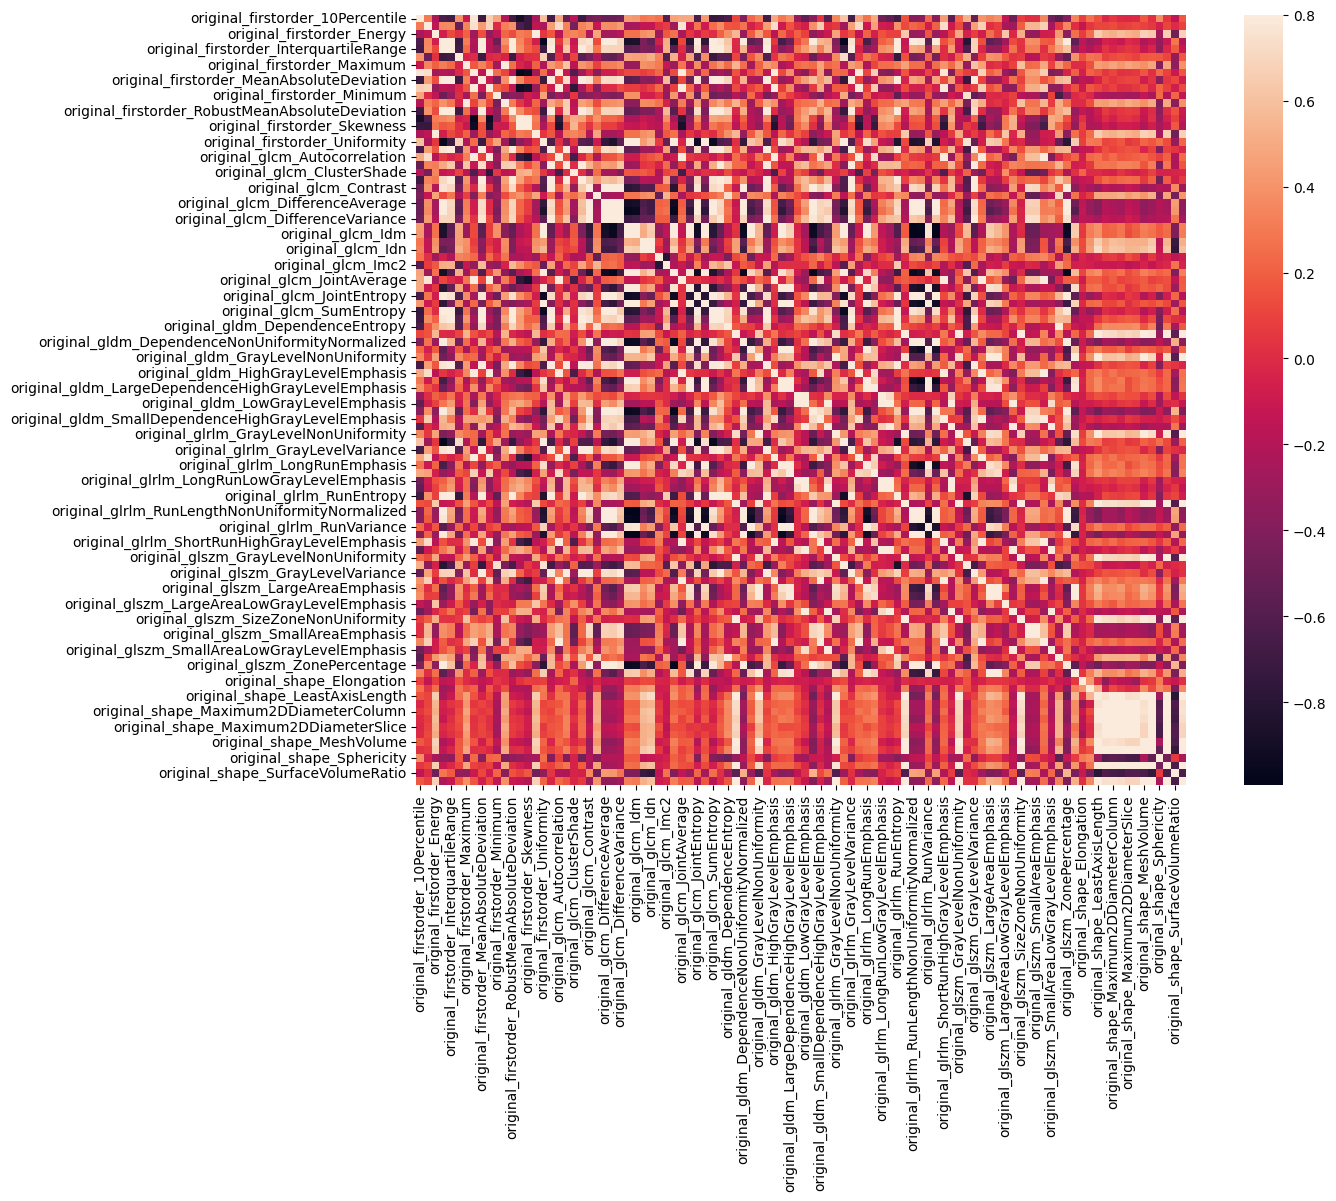

In [26]:


# Construct a pandas dataframe from the samples
d = pandas.DataFrame(data=samples, columns=feature_names)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

# Cluster the heatmap

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


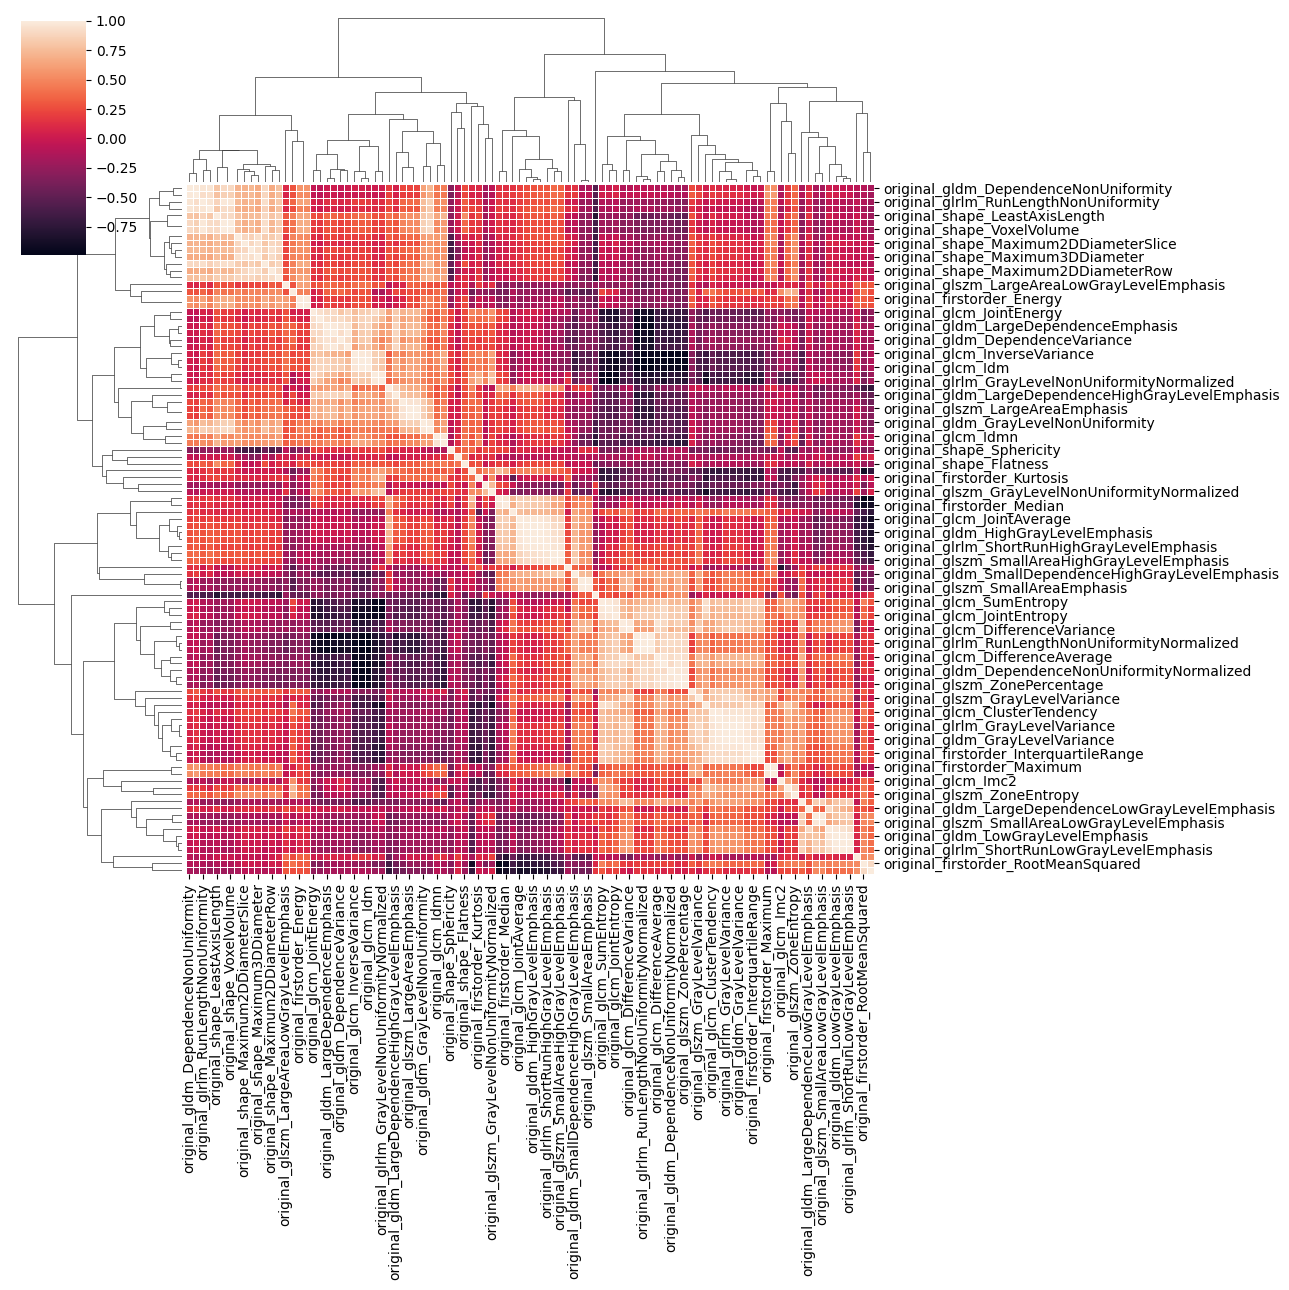

In [27]:
# Choose a subset of features for clustering
dd = d.iloc[:,:]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

# PCP

In [28]:
survival_status

,Survival Status,Case ID,uid,labels
49,Alive,R01-001,0,0
50,Alive,R01-002,1,0
51,Alive,R01-003,2,0
52,Alive,R01-004,3,0
53,Dead,R01-005,4,1
...,...,...,...,...
189,Alive,R01-141,132,0
190,Alive,R01-142,133,0
192,Alive,R01-144,134,0
193,Alive,R01-145,135,0


In [29]:
d['uid'] = np.arange(len(config_patinets))
d['survival_status'] = list(survival_status['labels'])
d

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,uid,survival_status
0,-443.0,41.0,1.552086e+08,4.496936,282.00,2.964832,154.0,-139.272894,162.692772,-56.0,...,25.709920,29.189039,2671.208333,17.071944,0.619611,1502.576894,0.562508,2719.0,0,0
1,-386.1,38.0,8.860778e+07,4.192986,183.75,4.442666,144.0,-105.572558,136.108386,-33.0,...,23.345235,24.372115,2119.875000,14.746690,0.694631,1148.868647,0.541951,2150.0,1,0
2,-324.4,106.0,4.174656e+07,4.332427,149.00,4.758523,290.0,-42.965257,129.546935,15.0,...,21.540659,23.043437,1305.666667,12.517767,0.731782,789.448259,0.604632,1324.0,2,0
3,-501.2,148.0,1.084852e+08,4.833568,244.00,4.179931,366.0,-74.679379,195.486103,21.0,...,22.472205,24.919872,1519.041667,16.282791,0.554125,1153.247825,0.759194,1547.0,3,0
4,-154.0,51.0,2.035543e+08,3.365276,59.00,10.191594,391.0,-25.891429,69.145645,6.0,...,49.678969,51.584882,16577.583333,28.311932,0.643186,4888.340653,0.294877,16625.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-855.0,114.0,3.098198e+09,5.647720,691.00,1.741596,827.0,-326.975698,334.293630,-271.0,...,53.150729,61.862751,12402.541667,26.136194,0.502754,5153.899338,0.415552,12468.0,132,0
133,-717.0,94.0,3.852615e+09,5.490919,530.00,1.921837,467.0,-276.532241,265.363025,-234.0,...,74.625733,79.063266,22565.375000,41.645936,0.456796,8453.886498,0.374640,22642.0,133,0
134,-838.0,37.0,2.283232e+09,5.456589,626.00,1.805940,495.0,-457.097741,300.308602,-560.0,...,50.249378,52.592775,6983.958333,34.377167,0.439001,4024.884575,0.576304,7039.0,134,0
135,-913.0,72.0,2.706531e+10,5.227012,780.00,2.610789,1350.0,-528.989135,365.137638,-743.0,...,75.286121,79.101201,60046.041667,50.970121,0.430395,17229.506925,0.286938,60195.0,135,0


In [30]:
d.columns

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median',
       ...
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'uid', 'survival_status'],
      dtype='object', length=102)

In [58]:
import numpy as np
count = 0
samples_full_data = np.zeros((len(config_patinets)+1,len(feature_names)+1))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        a = np.append(a,int(patient.strip('-')[-1]))
        samples_full_data[count,:] = a
        count +=1
# May have NaNs
samples_full_data = np.nan_to_num(samples_full_data)

In [32]:
survival_status

,Survival Status,Case ID,uid,labels
49,Alive,R01-001,0,0
50,Alive,R01-002,1,0
51,Alive,R01-003,2,0
52,Alive,R01-004,3,0
53,Dead,R01-005,4,1
...,...,...,...,...
189,Alive,R01-141,132,0
190,Alive,R01-142,133,0
192,Alive,R01-144,134,0
193,Alive,R01-145,135,0


In [72]:
survival_status['Case ID']

49     R01-001
50     R01-002
51     R01-003
52     R01-004
53     R01-005
        ...   
189    R01-141
190    R01-142
192    R01-144
193    R01-145
194    R01-146
Name: Case ID, Length: 137, dtype: object

In [146]:
all_features = feature_names + ['remove']
data = pandas.DataFrame(data=samples_full_data, columns=all_features)
data = data.iloc[:-1 , :]
data = data.iloc[:, :-1]
data['labels'] = survival_status['labels'].values
data['Patient_id'] = survival_status['Case ID'].values
data['survival_status'] = survival_status['Survival Status'].values

In [147]:
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume',
                                          'original_shape_SurfaceVolumeRatio'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

Show the distribution of different variables

In [79]:
# make a cleaner vefirst_colson
clean_df = df[feature_names].copy()
# clean_df.columns = [
#     ' '.join(c_col.split('original_')[-1].split('_')) 
#     for c_col in feature_names
# ]
clean_col_names = clean_df.columns[len(feature_names):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x: float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(3)

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
126,-840.0,136.0,1.520604e+10,5.572960,708.0,1.665402,688.0,-290.023001,344.952941,-163.0,...,98.954535,140.071410,120.066648,149.886624,65895.000000,66.722637,0.246191,32046.529495,0.486327,66128.0
6,-477.0,196.0,1.222365e+08,5.193181,320.0,3.241820,544.0,-68.209399,207.652930,5.0,...,18.788294,20.248457,21.023796,21.563859,1656.000000,14.967446,0.664132,1019.224160,0.615474,1681.0
111,-987.0,152.0,1.028979e+10,5.560091,875.0,1.689191,841.0,-480.757296,399.518425,-628.0,...,52.086467,58.240879,48.836462,64.791975,23868.416667,34.260578,0.471041,8510.880106,0.356575,23951.0


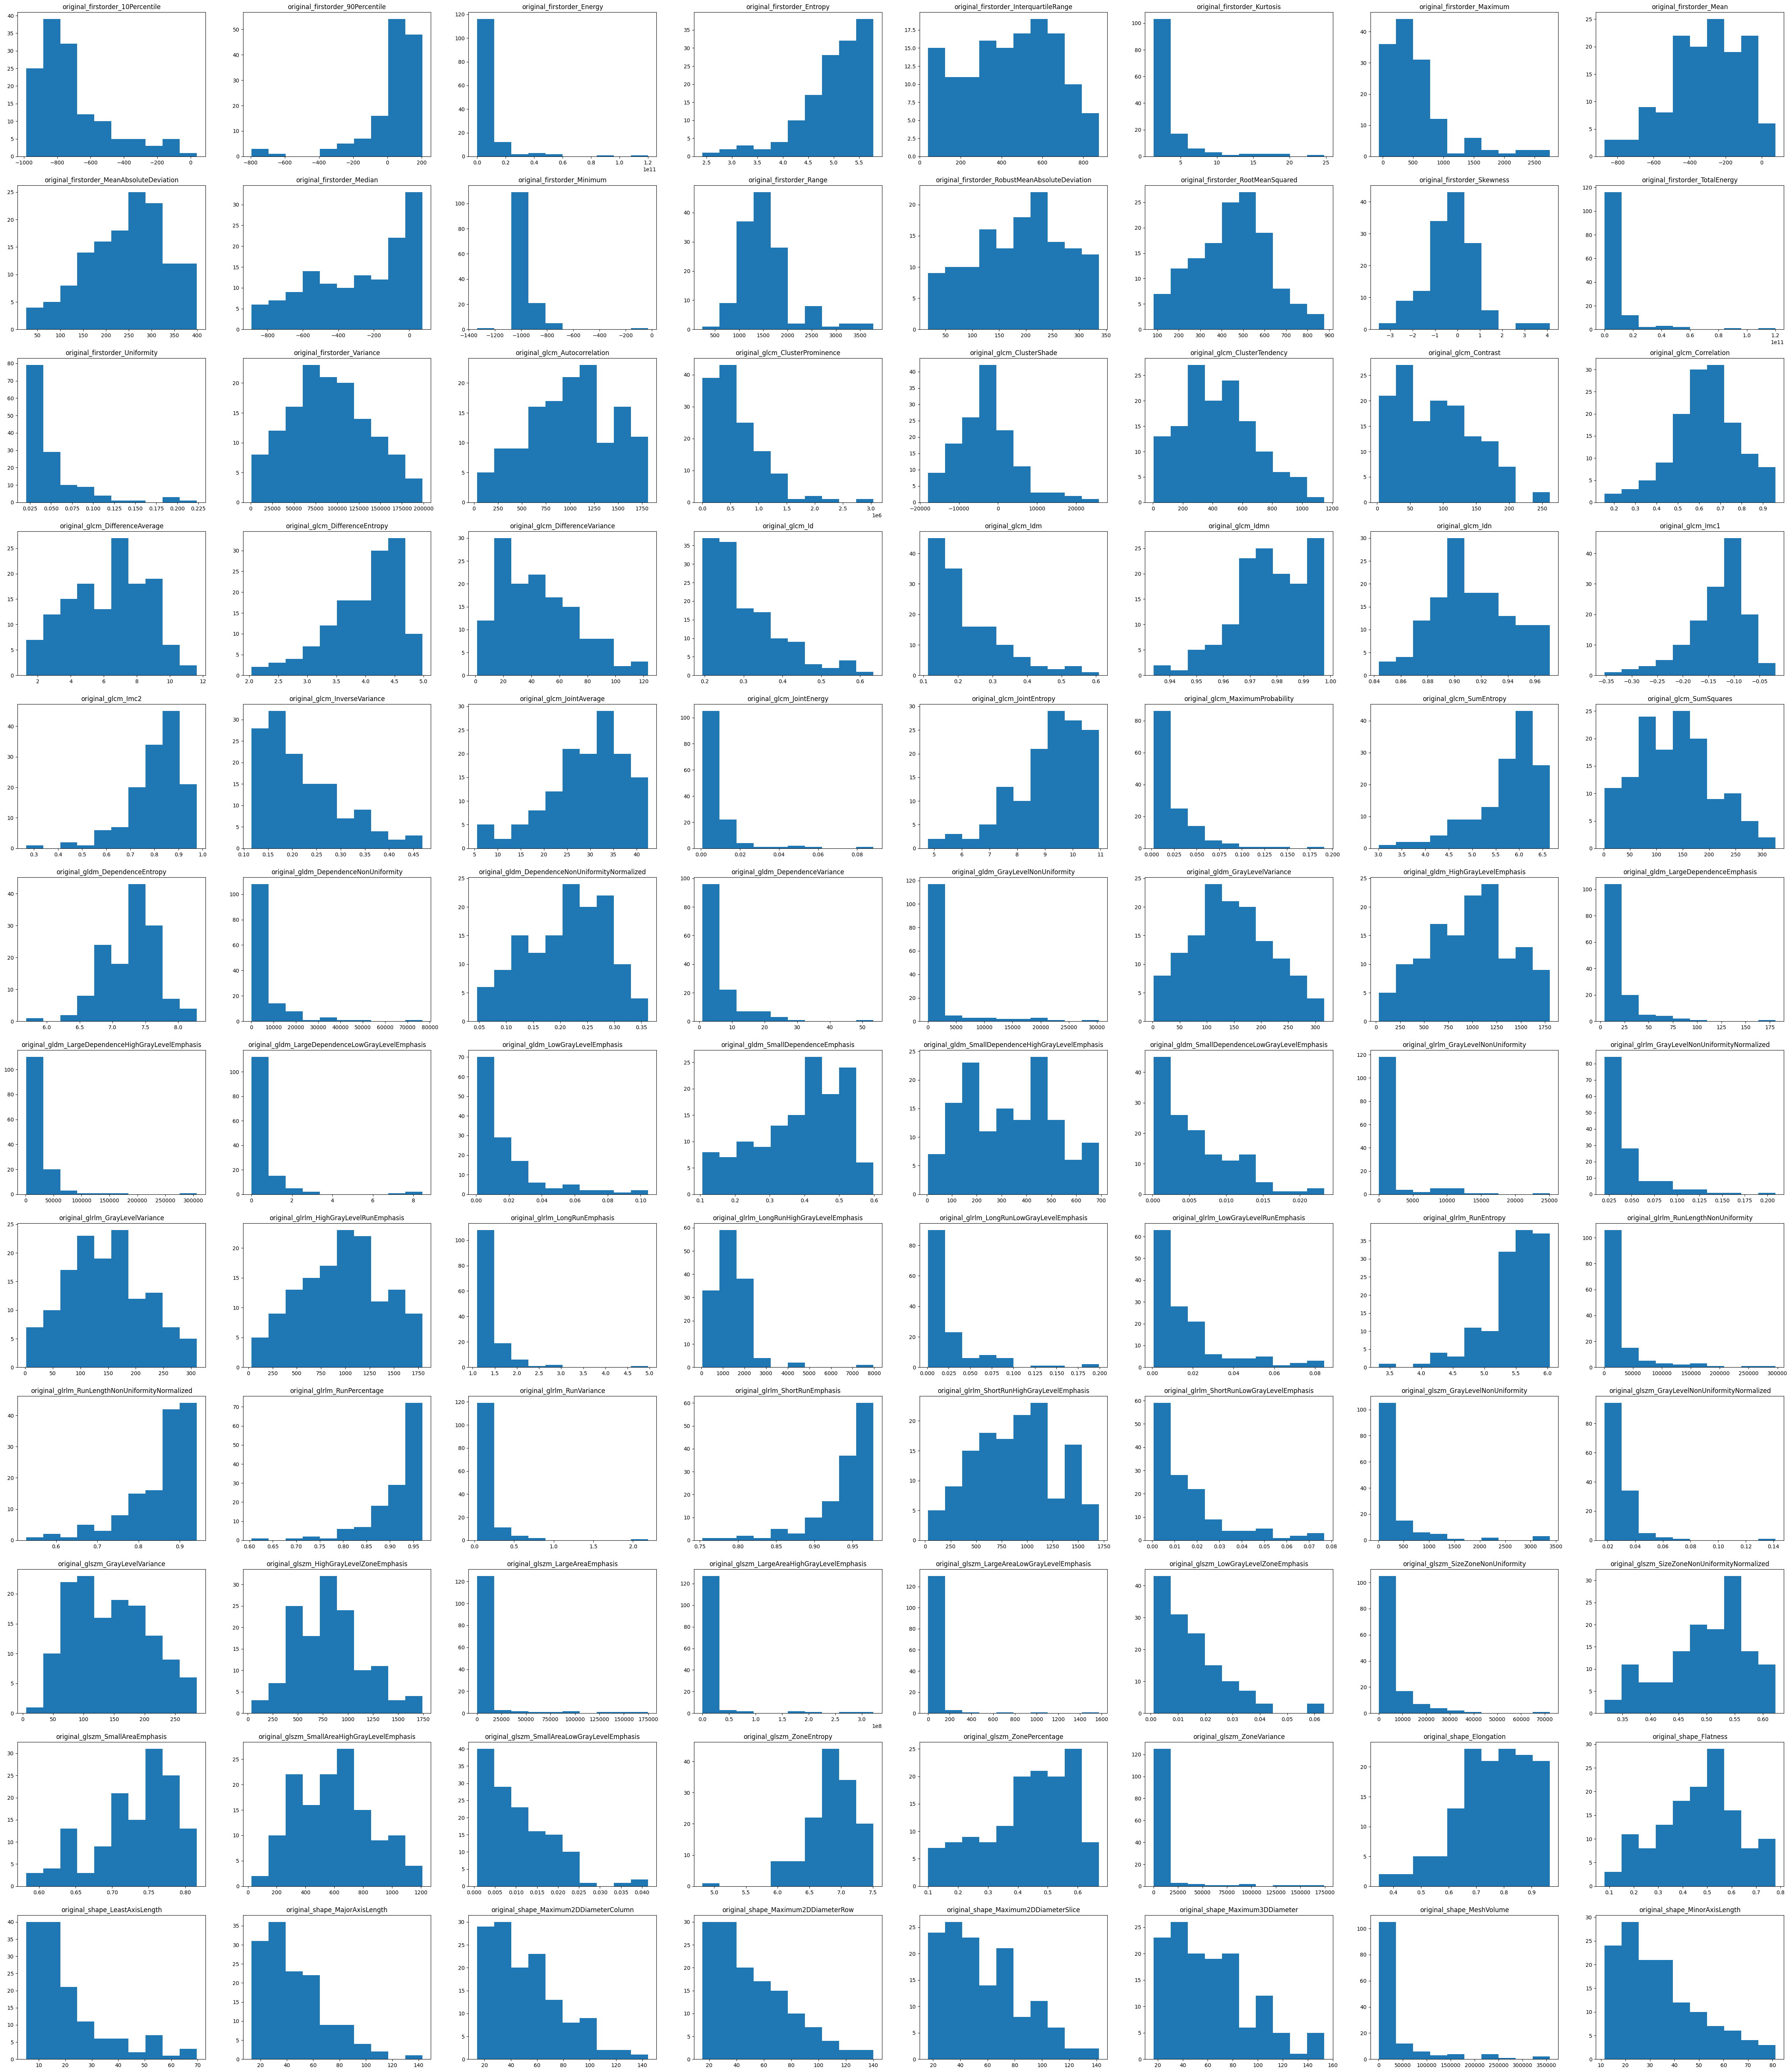

In [80]:
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), feature_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')

# Modeling without Feature Selection

In [149]:
dataset_all_features

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,labels,Patient_id,survival_status
0,-443.0,41.0,1.552086e+08,4.496936,282.00,2.964832,154.0,-139.272894,162.692772,-56.0,...,29.189039,2671.208333,17.071944,0.619611,1502.576894,0.562508,2719.0,0,R01-001,0
1,-386.1,38.0,8.860778e+07,4.192986,183.75,4.442666,144.0,-105.572558,136.108386,-33.0,...,24.372115,2119.875000,14.746690,0.694631,1148.868647,0.541951,2150.0,0,R01-002,0
2,-324.4,106.0,4.174656e+07,4.332427,149.00,4.758523,290.0,-42.965257,129.546935,15.0,...,23.043437,1305.666667,12.517767,0.731782,789.448259,0.604632,1324.0,0,R01-003,0
3,-501.2,148.0,1.084852e+08,4.833568,244.00,4.179931,366.0,-74.679379,195.486103,21.0,...,24.919872,1519.041667,16.282791,0.554125,1153.247825,0.759194,1547.0,0,R01-004,0
4,-154.0,51.0,2.035543e+08,3.365276,59.00,10.191594,391.0,-25.891429,69.145645,6.0,...,51.584882,16577.583333,28.311932,0.643186,4888.340653,0.294877,16625.0,1,R01-005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-855.0,114.0,3.098198e+09,5.647720,691.00,1.741596,827.0,-326.975698,334.293630,-271.0,...,61.862751,12402.541667,26.136194,0.502754,5153.899338,0.415552,12468.0,0,R01-141,0
133,-717.0,94.0,3.852615e+09,5.490919,530.00,1.921837,467.0,-276.532241,265.363025,-234.0,...,79.063266,22565.375000,41.645936,0.456796,8453.886498,0.374640,22642.0,0,R01-142,0
134,-838.0,37.0,2.283232e+09,5.456589,626.00,1.805940,495.0,-457.097741,300.308602,-560.0,...,52.592775,6983.958333,34.377167,0.439001,4024.884575,0.576304,7039.0,0,R01-144,0
135,-913.0,72.0,2.706531e+10,5.227012,780.00,2.610789,1350.0,-528.989135,365.137638,-743.0,...,79.101201,60046.041667,50.970121,0.430395,17229.506925,0.286938,60195.0,0,R01-145,0


In [150]:
dataset_all_features = data.copy()
class_mapping = {label: idx for idx, label in enumerate(np.unique(dataset_all_features['survival_status']))}
class_mapping
dataset_all_features['survival_status'] = dataset_all_features['survival_status'].map(class_mapping)
y = LabelEncoder().fit_transform(dataset_all_features['survival_status'].values)
X = dataset_all_features.iloc[:,0:len(dataset_all_features.columns)-3].values
print(y.shape)
print(X.shape)
feat_labels = dataset_all_features.columns[0:len(dataset_all_features.columns)-3]

(137,)
(137, 100)


In [82]:
dataset_all_features

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,Patient_id,labels,survival_status
0,-443.0,41.0,1.552086e+08,4.496936,282.00,2.964832,154.0,-139.272894,162.692772,-56.0,...,29.189039,2671.208333,17.071944,0.619611,1502.576894,0.562508,2719.0,R01-001,0,0
1,-386.1,38.0,8.860778e+07,4.192986,183.75,4.442666,144.0,-105.572558,136.108386,-33.0,...,24.372115,2119.875000,14.746690,0.694631,1148.868647,0.541951,2150.0,R01-002,0,0
2,-324.4,106.0,4.174656e+07,4.332427,149.00,4.758523,290.0,-42.965257,129.546935,15.0,...,23.043437,1305.666667,12.517767,0.731782,789.448259,0.604632,1324.0,R01-003,0,0
3,-501.2,148.0,1.084852e+08,4.833568,244.00,4.179931,366.0,-74.679379,195.486103,21.0,...,24.919872,1519.041667,16.282791,0.554125,1153.247825,0.759194,1547.0,R01-004,0,0
4,-154.0,51.0,2.035543e+08,3.365276,59.00,10.191594,391.0,-25.891429,69.145645,6.0,...,51.584882,16577.583333,28.311932,0.643186,4888.340653,0.294877,16625.0,R01-005,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-855.0,114.0,3.098198e+09,5.647720,691.00,1.741596,827.0,-326.975698,334.293630,-271.0,...,61.862751,12402.541667,26.136194,0.502754,5153.899338,0.415552,12468.0,R01-141,0,0
133,-717.0,94.0,3.852615e+09,5.490919,530.00,1.921837,467.0,-276.532241,265.363025,-234.0,...,79.063266,22565.375000,41.645936,0.456796,8453.886498,0.374640,22642.0,R01-142,0,0
134,-838.0,37.0,2.283232e+09,5.456589,626.00,1.805940,495.0,-457.097741,300.308602,-560.0,...,52.592775,6983.958333,34.377167,0.439001,4024.884575,0.576304,7039.0,R01-144,0,0
135,-913.0,72.0,2.706531e+10,5.227012,780.00,2.610789,1350.0,-528.989135,365.137638,-743.0,...,79.101201,60046.041667,50.970121,0.430395,17229.506925,0.286938,60195.0,R01-145,0,0


In [87]:
LabelEncoder().fit_transform(dataset_all_features['survival_status'].values)

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1])

In [88]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print(X_std.shape)

(137, 100)


In [89]:
RF_xy_trainlist = []
RF_xy_testlist = []
# dataset
X, y = X_std, y
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	RF_xy_trainlist.append([X_train,y_train ])
	RF_xy_testlist.append([X_test, y_test])
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
	# define the model
	model = RandomForestClassifier(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [10, 100, 500]
	space['min_samples_leaf'] = [5,10,15,20]
	space['criterion'] = ["gini","entropy","log_loss"]
	# space['max_features'] = [10,15,20]
	
	# define search
	search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = accuracy_score(y_test, yhat)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (statistics.mean(outer_results), statistics.stdev(outer_results)))

>acc=0.857, est=0.618, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
>acc=0.286, est=0.667, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 100}
>acc=0.571, est=0.659, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.643, est=0.659, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 500}
>acc=0.500, est=0.659, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.714, est=0.634, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
>acc=0.643, est=0.666, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 500}
>acc=0.538, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 100}
>acc=0.615, est=0.661, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 10}
>acc=0.538, est=0.637, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 100}
Accuracy: 0.591 (0.149)


The optimal settings that we selected are 



>acc=0.857, est=0.618, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}

In [102]:
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (statistics.mean(outer_results), statistics.stdev(outer_results)))

Accuracy: 0.613 (0.137)


In [91]:
forest = RandomForestClassifier(bootstrap=True,criterion='gini',oob_score=True,n_jobs=-1,n_estimators=10,min_samples_leaf=20,random_state=1,class_weight='balanced')
cv = StratifiedKFold(n_splits=10)

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/77865954.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed

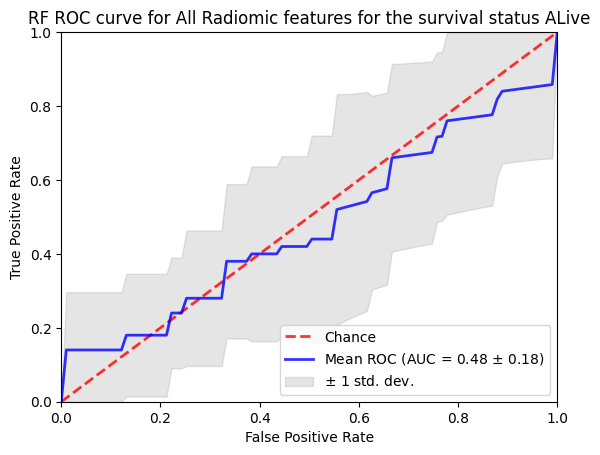

In [93]:

classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3931663337.py:10: DeprecationWarning:

scipy.interp is deprecated and w

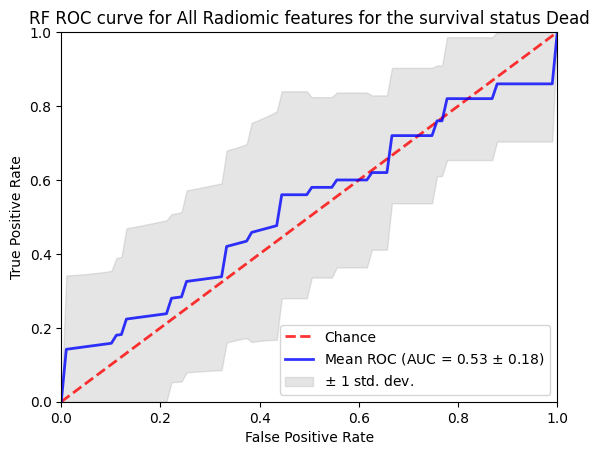

In [94]:
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for All Radiomic features for the survival status Dead')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

# Feature Selection

After analysing the features from the maps above, we will now clean the dataframe with highly correlated variable since they will cause strong assumptions.
Now to do so , we have different techniques , proposed following

In [95]:
data_with_selected_Features1 = df.copy()
# get upper triangle of correlation matrix
corr_matrix =  corr

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8))

# find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# drop highly correlated features

data_with_selected_Features1.drop(to_drop, axis=1, inplace=True)

In [96]:
data_with_selected_Features1.info()
df_drop = data_with_selected_Features1.dropna(axis=0)
df_drop.replace([np.inf, -np.inf],np.nan,inplace=True)
df_drop.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 25 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   original_firstorder_10Percentile                   137 non-null    float64
 1   original_firstorder_90Percentile                   137 non-null    float64
 2   original_firstorder_Energy                         137 non-null    float64
 3   original_firstorder_Entropy                        137 non-null    float64
 4   original_firstorder_Kurtosis                       137 non-null    float64
 5   original_firstorder_Maximum                        137 non-null    float64
 6   original_firstorder_Minimum                        137 non-null    float64
 7   original_firstorder_RootMeanSquared                137 non-null    float64
 8   original_firstorder_Uniformity                     137 non-null    float64
 9   original_g

In [ ]:
# import plotly.express as px
# df = d
# fig = px.parallel_coordinates(data_with_selected_Features1,
#                               dimensions=['uid','survival_status','original_shape_Elongation', 'original_shape_Flatness', 'original_shape_Sphericity',
#                                           'original_shape_SurfaceVolumeRatio'],
#                               color_continuous_scale=px.colors.diverging.Tealrose,
#                               color_continuous_midpoint=2)
# fig.show()

# Random Forest

In [97]:
data_with_selected_Features1

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Minimum,original_firstorder_RootMeanSquared,original_firstorder_Uniformity,original_glcm_ClusterShade,...,original_gldm_GrayLevelNonUniformity,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_shape_Elongation,original_shape_Flatness,original_shape_Sphericity,original_shape_SurfaceVolumeRatio,Patient_id,labels,survival_status
0,-443.0,41.0,1.552086e+08,4.496936,2.964832,154.0,-812.0,238.920446,0.063359,-2285.722545,...,172.271791,0.029890,0.262969,0.781483,0.544028,0.619611,0.562508,R01-001,0,Alive
1,-386.1,38.0,8.860778e+07,4.192986,4.442666,144.0,-829.0,203.009652,0.082164,-1550.034184,...,176.652093,0.019846,0.310598,0.788934,0.624390,0.694631,0.541951,R01-002,0,Alive
2,-324.4,106.0,4.174656e+07,4.332427,4.758523,290.0,-815.0,177.568667,0.073279,-1272.245157,...,97.021148,0.015880,0.128019,0.703124,0.511875,0.731782,0.604632,R01-003,0,Alive
3,-501.2,148.0,1.084852e+08,4.833568,4.179931,366.0,-1024.0,264.813482,0.051739,-5332.149814,...,80.040724,0.008517,0.045259,0.747805,0.367115,0.554125,0.759194,R01-004,0,Alive
4,-154.0,51.0,2.035543e+08,3.365276,10.191594,391.0,-783.0,110.652020,0.151074,-592.882657,...,2511.602466,0.050188,11.347724,0.679139,0.509750,0.643186,0.294877,R01-005,1,Dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-855.0,114.0,3.098198e+09,5.647720,1.741596,827.0,-1024.0,498.489716,0.022065,-7378.929982,...,275.104427,0.558159,0.542136,0.549257,0.363463,0.502754,0.415552,R01-141,0,Alive
133,-717.0,94.0,3.852615e+09,5.490919,1.921837,467.0,-1023.0,412.496662,0.024132,-4279.622271,...,546.402791,0.013118,0.022581,0.698212,0.251463,0.456796,0.374640,R01-142,0,Alive
134,-838.0,37.0,2.283232e+09,5.456589,1.805940,495.0,-1024.0,569.533886,0.026113,2998.089218,...,183.808069,0.094926,0.110446,0.966172,0.302722,0.439001,0.576304,R01-144,0,Alive
135,-913.0,72.0,2.706531e+10,5.227012,2.610789,1350.0,-1024.0,670.542515,0.036645,25788.848345,...,2205.816746,0.265266,14.489349,0.926823,0.612889,0.430395,0.286938,R01-145,0,Alive


In [98]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
class_mapping
df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
print(y.shape)
print(X.shape)

(137,)
(137, 22)


In [99]:
feat_labels = df_drop.columns[0:len(df_drop.columns)-3]

In [100]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print(X_std.shape)

(137, 22)


With Cv and hyper parameter tunning

In [101]:
RF_xy_trainlist = []
RF_xy_testlist = []
# dataset
X, y = X_std, y
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	RF_xy_trainlist.append([X_train,y_train ])
	RF_xy_testlist.append([X_test, y_test])
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
	# define the model
	model = RandomForestClassifier(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [10, 100, 500]
	space['min_samples_leaf'] = [5,10,15,20]
	space['criterion'] = ["gini","entropy","log_loss"]
	# space['max_features'] = [10,15,20]
	
	# define search
	search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = accuracy_score(y_test, yhat)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.857, est=0.626, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.429, est=0.691, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.500, est=0.650, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 500}
>acc=0.643, est=0.659, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 10}
>acc=0.571, est=0.667, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.786, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
>acc=0.571, est=0.650, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
>acc=0.692, est=0.645, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 500}
>acc=0.462, est=0.653, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
>acc=0.615, est=0.637, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
Accuracy: 0.613 (0.130)


so you can see that the best pramas for RF are >acc=0.786, est=0.625, cfg={'criterion': 'gini', 'max_features': 15, 'min_samples_leaf': 20, 'n_estimators': 10}

In [126]:
forest = RandomForestClassifier(bootstrap=True,criterion='entropy',oob_score=True,n_jobs=-1,n_estimators=10,min_samples_leaf=5,random_state=1,class_weight='balanced')
cv = StratifiedKFold(n_splits=10)

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/3225200222.py:10: DeprecationWarning:

scipy.interp is deprecated and w

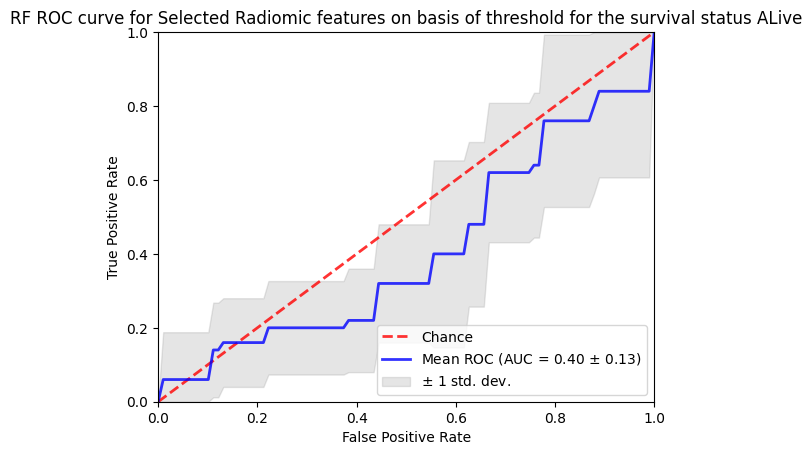

In [127]:
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for Selected Radiomic features on basis of threshold for the survival status ALive')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/807454244.py:10: DeprecationWarning:

scipy.interp is deprecated and will be 

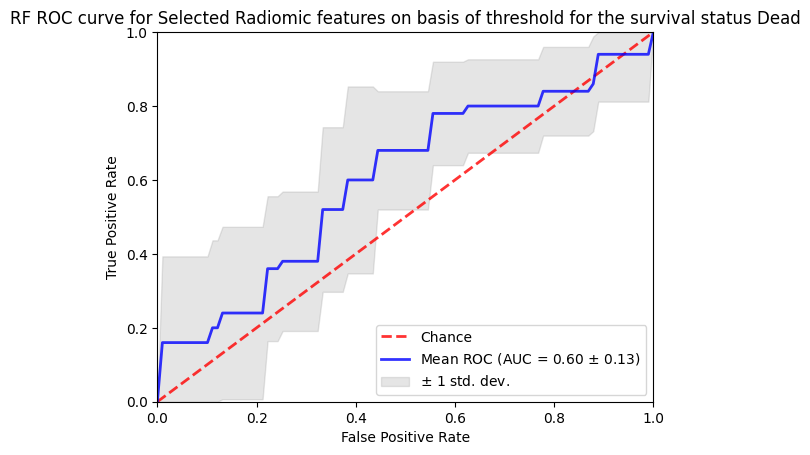

In [128]:
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for Selected Radiomic features on basis of threshold for the survival status Dead')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

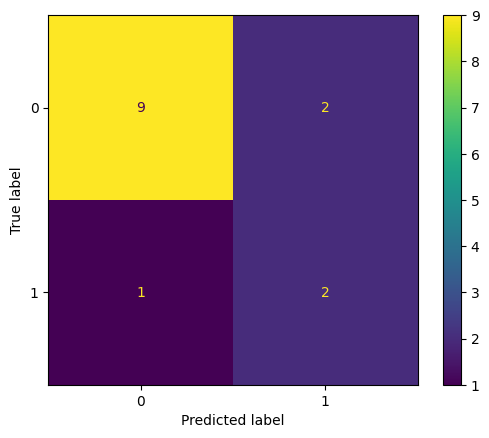

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, RF_xy_testlist[0][0], RF_xy_testlist[0][1])

# SVM

In [130]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
#

In [131]:

# dataset
X, y = X_std, y

xy_trainlist = []

xy_testlist = []
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	xy_trainlist.append([X_train,y_train ])
	xy_testlist.append([X_test, y_test])
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
	# define the model
	model = SVC(random_state=1)
	# define search space
	space = dict()
	space['kernel'] = ["poly", "rbf", "sigmoid"]
	# space['gamma'] = ["scale","auto"]
	space['C'] = [1,10,50,100]
	space["decision_function_shape"] = ['ovo','ovr']
	
	# define search
	search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True,return_train_score=True)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = accuracy_score(y_test, yhat)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.857, est=0.651, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
>acc=0.429, est=0.700, cfg={'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
>acc=0.500, est=0.659, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
>acc=0.643, est=0.683, cfg={'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
>acc=0.500, est=0.643, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
>acc=0.786, est=0.618, cfg={'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
>acc=0.643, est=0.634, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
>acc=0.846, est=0.669, cfg={'C': 1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
>acc=0.538, est=0.669, cfg={'C': 100, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
>acc=0.615, est=0.661, cfg={'C': 50, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
Accuracy: 0.636 (0.143)


In [132]:
from sklearn.model_selection import StratifiedKFold
svm = SVC(kernel='sigmoid', C=1,shrinking=False,probability=True,decision_function_shape='ovo',random_state=1)
cv = StratifiedKFold(n_splits=10)


/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/2489517443.py:11: DeprecationWarning:

scipy.interp is deprecated and w

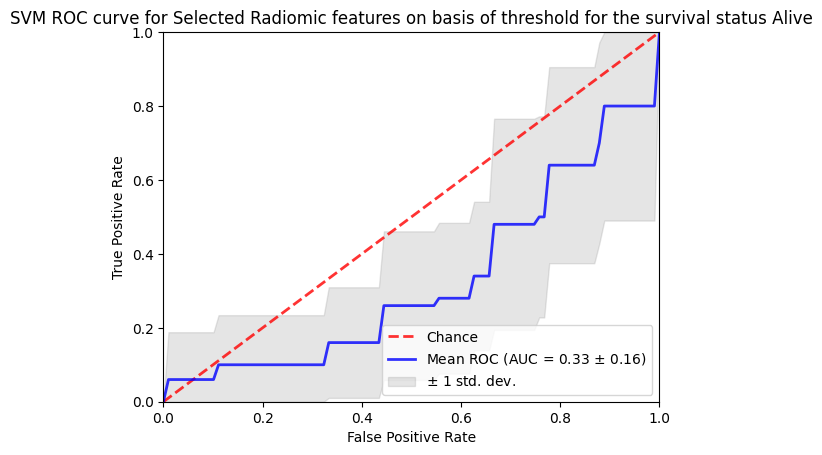

In [133]:
classifier = svm
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # clf.score(X_test, y_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC curve for Selected Radiomic features on basis of threshold for the survival status Alive')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/414601914.py:11: DeprecationWarning:

scipy.interp is deprecated and will be 

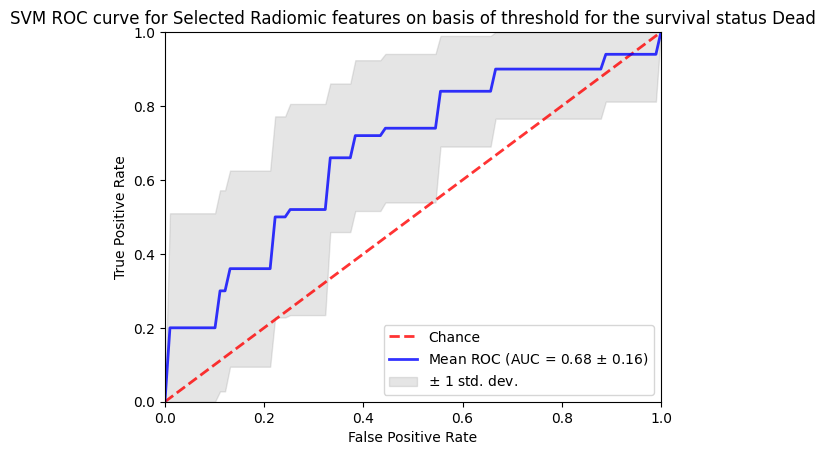

In [135]:
classifier = svm
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # clf.score(X_test, y_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC curve for Selected Radiomic features on basis of threshold for the survival status Dead')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

In [136]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.30, random_state=1)
cross_val_score(classifier, X, y, cv=cv)

array([0.64285714, 0.71428571, 0.69047619, 0.69047619, 0.71428571,
       0.71428571, 0.69047619, 0.61904762, 0.69047619, 0.57142857])

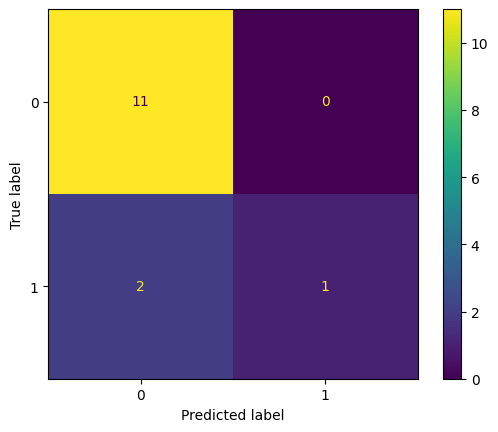

In [137]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, xy_testlist[0][0], xy_testlist[0][1])

# LASSO

In [151]:
data

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,labels,Patient_id,survival_status
0,-443.0,41.0,1.552086e+08,4.496936,282.00,2.964832,154.0,-139.272894,162.692772,-56.0,...,29.189039,2671.208333,17.071944,0.619611,1502.576894,0.562508,2719.0,0,R01-001,Alive
1,-386.1,38.0,8.860778e+07,4.192986,183.75,4.442666,144.0,-105.572558,136.108386,-33.0,...,24.372115,2119.875000,14.746690,0.694631,1148.868647,0.541951,2150.0,0,R01-002,Alive
2,-324.4,106.0,4.174656e+07,4.332427,149.00,4.758523,290.0,-42.965257,129.546935,15.0,...,23.043437,1305.666667,12.517767,0.731782,789.448259,0.604632,1324.0,0,R01-003,Alive
3,-501.2,148.0,1.084852e+08,4.833568,244.00,4.179931,366.0,-74.679379,195.486103,21.0,...,24.919872,1519.041667,16.282791,0.554125,1153.247825,0.759194,1547.0,0,R01-004,Alive
4,-154.0,51.0,2.035543e+08,3.365276,59.00,10.191594,391.0,-25.891429,69.145645,6.0,...,51.584882,16577.583333,28.311932,0.643186,4888.340653,0.294877,16625.0,1,R01-005,Dead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-855.0,114.0,3.098198e+09,5.647720,691.00,1.741596,827.0,-326.975698,334.293630,-271.0,...,61.862751,12402.541667,26.136194,0.502754,5153.899338,0.415552,12468.0,0,R01-141,Alive
133,-717.0,94.0,3.852615e+09,5.490919,530.00,1.921837,467.0,-276.532241,265.363025,-234.0,...,79.063266,22565.375000,41.645936,0.456796,8453.886498,0.374640,22642.0,0,R01-142,Alive
134,-838.0,37.0,2.283232e+09,5.456589,626.00,1.805940,495.0,-457.097741,300.308602,-560.0,...,52.592775,6983.958333,34.377167,0.439001,4024.884575,0.576304,7039.0,0,R01-144,Alive
135,-913.0,72.0,2.706531e+10,5.227012,780.00,2.610789,1350.0,-528.989135,365.137638,-743.0,...,79.101201,60046.041667,50.970121,0.430395,17229.506925,0.286938,60195.0,0,R01-145,Alive


In [160]:
X = data.iloc[:,0:len(data.columns)-3]
y = data['labels'].values

In [162]:
scaler = StandardScaler()
scaler.fit(X)
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
sel_.fit(scaler.transform(X), y)
removed_feats = X.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
lasso_data = X.drop(columns=removed_feats, axis = 1)

Now we will try Random Forest and SV to see the results

In [163]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(lasso_data.iloc[:].values)
RF_xy_trainlist = []
RF_xy_testlist = []
# dataset
X, y = X_std, y
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	RF_xy_trainlist.append([X_train,y_train ])
	RF_xy_testlist.append([X_test, y_test])
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
	# define the model
	model = RandomForestClassifier(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [10, 100, 500]
	space['min_samples_leaf'] = [5,10,15,20]
	space['criterion'] = ["gini","entropy","log_loss"]
	# space['max_features'] = [10,15,20]
	
	# define search
	search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = accuracy_score(y_test, yhat)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.643, est=0.651, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.286, est=0.667, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 100}
>acc=0.500, est=0.659, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.571, est=0.675, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
>acc=0.500, est=0.659, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.786, est=0.634, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.643, est=0.650, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
>acc=0.538, est=0.661, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.538, est=0.645, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.462, est=0.637, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
Accuracy: 0.547 (0.125)


In [164]:
forest = RandomForestClassifier(bootstrap=True,criterion='gini',oob_score=True,n_jobs=-1,
                                n_estimators=10,min_samples_leaf=15,random_state=1,class_weight='balanced_subsample')
cv = StratifiedKFold(n_splits=10)
classifier = forest

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/958996585.py:10: DeprecationWarning:

scipy.interp is deprecated and will be 

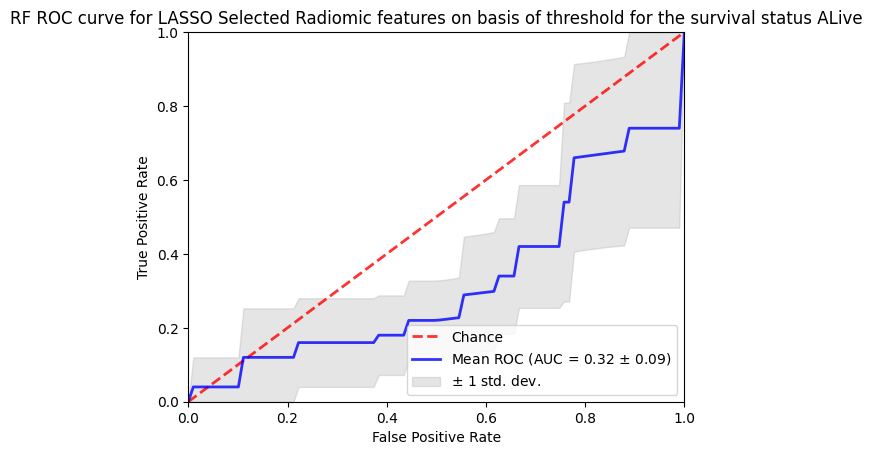

In [168]:
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for LASSO Selected Radiomic features on basis of threshold for the survival status ALive')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_4065353/271655439.py:10: DeprecationWarning:

scipy.interp is deprecated and will be 

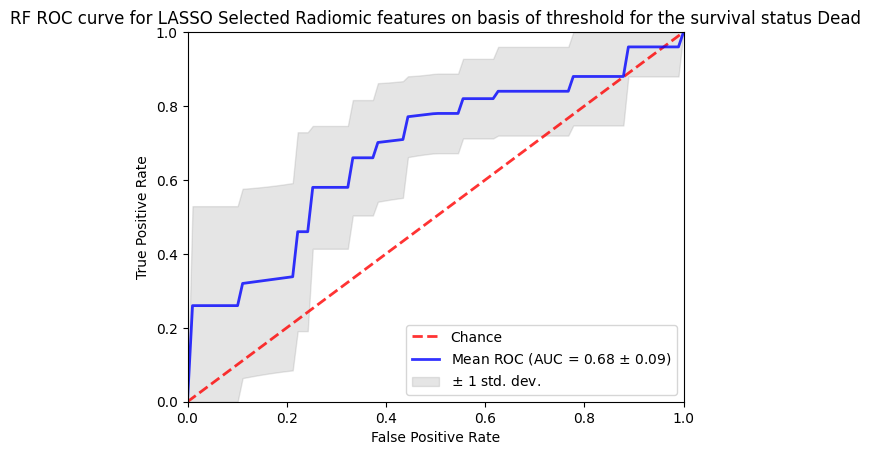

In [167]:
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X_std, y):
    probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for LASSO Selected Radiomic features on basis of threshold for the survival status Dead')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

In [ ]:
from sklearn import metrics
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

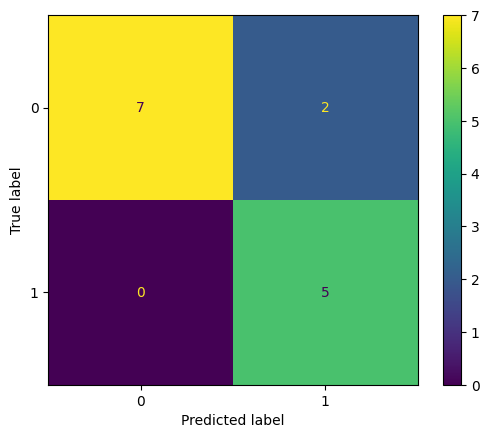

In [154]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, RF_xy_testlist[5][0], RF_xy_testlist[5][1])

# Feature Selection with Anova

In [169]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

df_anova = df.copy()

In [170]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df_anova['survival_status']))}
class_mapping
df_anova['survival_status'] = df_anova['survival_status'].map(class_mapping)
y_anova = LabelEncoder().fit_transform(df_anova['survival_status'].values)
X_anova = df_anova.iloc[:,0:len(df_anova.columns)-3].values
print(y_anova.shape)
print(X_anova.shape)

(137,)
(137, 100)


In [171]:
selector = SelectKBest(f_classif, k=20) # k is the number of features to be selected
X_new = selector.fit_transform(X_anova, y_anova)
# print('feature importance: ', selector.scores_)
# print('pvalues: ', selector.pvalues_)
# len(selector.pvalues_)
columns = data_with_selected_Features1.columns
feature_scores = list(zip(selector.scores_,columns))
sorted_feature_scores = sorted(feature_scores,reverse=True)
print(columns)
print(feature_scores)

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_firstorder_RootMeanSquared',
       'original_firstorder_Uniformity', 'original_glcm_ClusterShade',
       'original_glcm_Correlation', 'original_glcm_Idmn', 'original_glcm_Imc1',
       'original_glcm_Imc2', 'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_LargeAreaLowGrayLevelEmphasis',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
       'Patient_id', 'labels', 'survival_status'],
      dtype='object')
[(0.5407456289364786, 'original_firstorder_10Percentile'), (0.7747164604501581, 'original_firstorder_90Percentile'

In [172]:
num_list = []
col_list = []
for i in range(len(columns)):
   num_list.append((sorted_feature_scores[i])[0])
   col_list.append((sorted_feature_scores [i])[1])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'original_shape_Sphericity'),
  Text(1, 0, 'original_glcm_ClusterShade'),
  Text(2, 0, 'original_gldm_LargeDependenceLowGrayLevelEmphasis'),
  Text(3, 0, 'original_firstorder_Minimum'),
  Text(4, 0, 'original_shape_Elongation'),
  Text(5, 0, 'original_glcm_Idmn'),
  Text(6, 0, 'original_firstorder_RootMeanSquared'),
  Text(7, 0, 'original_firstorder_Entropy'),
  Text(8, 0, 'original_firstorder_Maximum'),
  Text(9, 0, 'original_glcm_Imc2')])

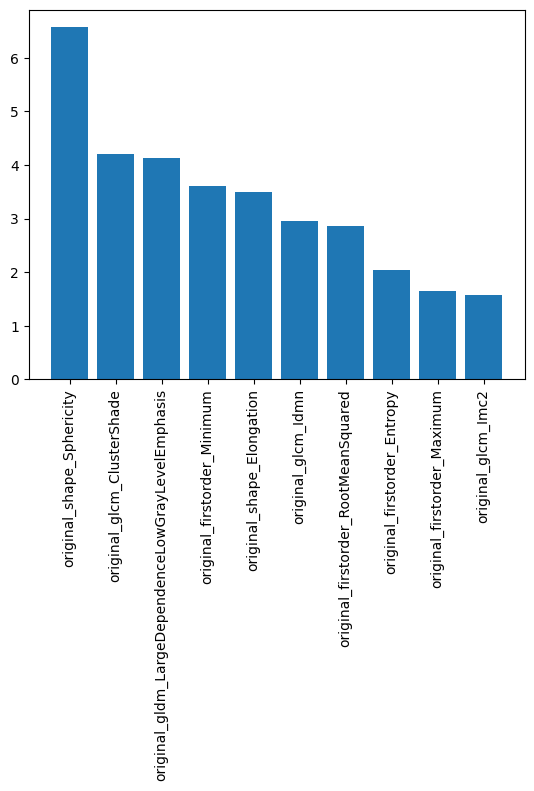

In [173]:
plt.bar(col_list[0:10],num_list[0:10])
plt.xticks(rotation=90)

In [174]:
dfn = 2 # Inter-level degrees of freedom(3-1)
dfd = 98 # Intra-level degrees of freedom(2345-2)

AttributeError: 'Figure' object has no attribute 'ppf'

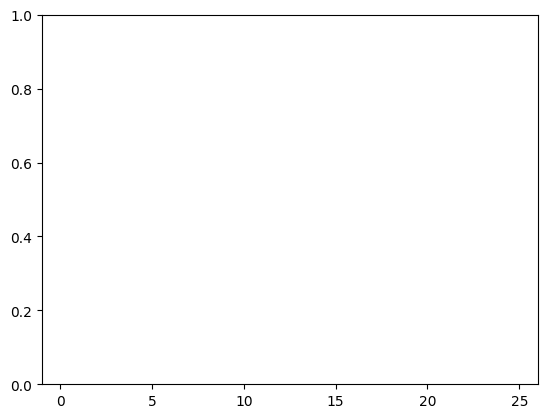

In [175]:
fig, ax = plt.subplots(1, 1)

plt.xlim(-1,26)
plt.ylim(0,1)
x = np.linspace(f.ppf(0.0000000001, dfn, dfd),f.ppf(0.9999999999, dfn, dfd), 100)
ax.plot(x, f.pdf(x, dfn, dfd), 'r-')
ax.axvline(f.ppf(0.95, dfn, dfd), ls = "--", color = "navy")
print('upper 5%:', f.ppf(0.95, dfn, dfd))

In [176]:
importance = pd.DataFrame(num_list,index=col_list,columns=['importance'])
importance

,importance
original_shape_Sphericity,6.573631
original_glcm_ClusterShade,4.208725
original_gldm_LargeDependenceLowGrayLevelEmphasis,4.126936
original_firstorder_Minimum,3.614800
original_shape_Elongation,3.496002
original_glcm_Idmn,2.960553
original_firstorder_RootMeanSquared,2.854392
original_firstorder_Entropy,2.044888
original_firstorder_Maximum,1.641741
original_glcm_Imc2,1.574312


In [177]:
top_features = importance.nlargest(5, 'importance')
print(top_features.index)

Index(['original_shape_Sphericity', 'original_glcm_ClusterShade',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_firstorder_Minimum', 'original_shape_Elongation'],
      dtype='object')


In [178]:
anova_selected_df = df_anova.copy()
anova_selected_df  = anova_selected_df[anova_selected_df.columns.intersection(top_features.index)]
anova_selected_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   original_firstorder_Minimum                        137 non-null    float64
 1   original_glcm_ClusterShade                         137 non-null    float64
 2   original_gldm_LargeDependenceLowGrayLevelEmphasis  137 non-null    float64
 3   original_shape_Elongation                          137 non-null    float64
 4   original_shape_Sphericity                          137 non-null    float64
dtypes: float64(5)
memory usage: 5.5 KB


In [179]:
from sklearn.preprocessing import StandardScaler
X_anova = anova_selected_df.values
stdsc = StandardScaler()
X_std_anova = stdsc.fit_transform(X_anova)
print(X_std_anova.shape)

(137, 5)


In [181]:
RF_xy_trainlist = []
RF_xy_testlist = []
# dataset
X, y = X_std_anova, y
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
	# split data
	X_train, X_test = X[train_ix, :], X[test_ix, :]
	y_train, y_test = y[train_ix], y[test_ix]
	RF_xy_trainlist.append([X_train,y_train ])
	RF_xy_testlist.append([X_test, y_test])
	# configure the cross-validation procedure
	cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
	# define the model
	model = RandomForestClassifier(random_state=1)
	# define search space
	space = dict()
	space['n_estimators'] = [10, 100, 500]
	space['min_samples_leaf'] = [5,10,15,20]
	space['criterion'] = ["gini","entropy","log_loss"]
	# space['max_features'] = [10,15,20]
	
	# define search
	search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
	# execute search
	result = search.fit(X_train, y_train)
	# get the best performing model fit on the whole training set
	best_model = result.best_estimator_
	# evaluate model on the hold out dataset
	yhat = best_model.predict(X_test)
	# evaluate the model
	acc = accuracy_score(y_test, yhat)
	# store the result
	outer_results.append(acc)
	# report progress
	print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

>acc=0.714, est=0.618, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
>acc=0.429, est=0.699, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.571, est=0.650, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.500, est=0.651, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 100}
>acc=0.429, est=0.659, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.714, est=0.634, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
>acc=0.786, est=0.625, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
>acc=0.769, est=0.629, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
>acc=0.462, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
>acc=0.538, est=0.637, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 10}
Accuracy: 0.591 (0.135)


In [185]:
forest = RandomForestClassifier(bootstrap=True,criterion='entropy',oob_score=True,n_jobs=-1,
                                n_estimators=100,min_samples_leaf=5,random_state=1,class_weight='balanced')


/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_696597/1053290011.py:11: DeprecationWarning:

scipy.interp is deprecated and will be 

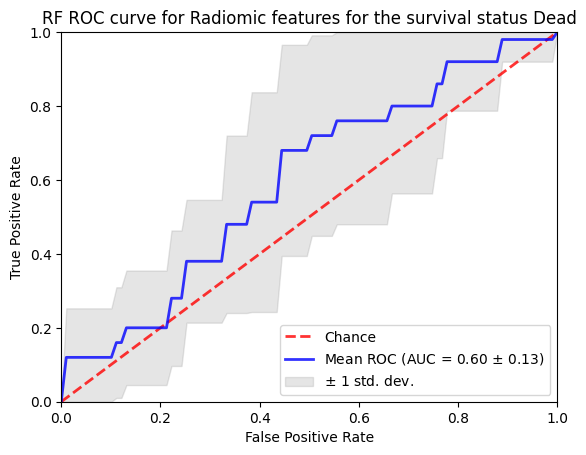

In [187]:
i = 0
cv = StratifiedKFold(n_splits=10)
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train, test in cv.split(X_std_anova, y):
    probas_ = classifier.fit(X_std_anova[train], y[train]).predict_proba(X_std_anova[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for ANOVA Radiomic features for the survival status Dead')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

In [ ]:
i = 0
cv = StratifiedKFold(n_splits=10)
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train, test in cv.split(X_std_anova, y):
    probas_ = classifier.fit(X_std_anova[train], y[train]).predict_proba(X_std_anova[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for ANOVA Radiomic features for the survival status Alive')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_std_anova[test], y[test])

ValueError: X has 20 features, but RandomForestClassifier is expecting 3 features as input.

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_3345490/1387004138.py:11: DeprecationWarning:

scipy.interp is deprecated and w

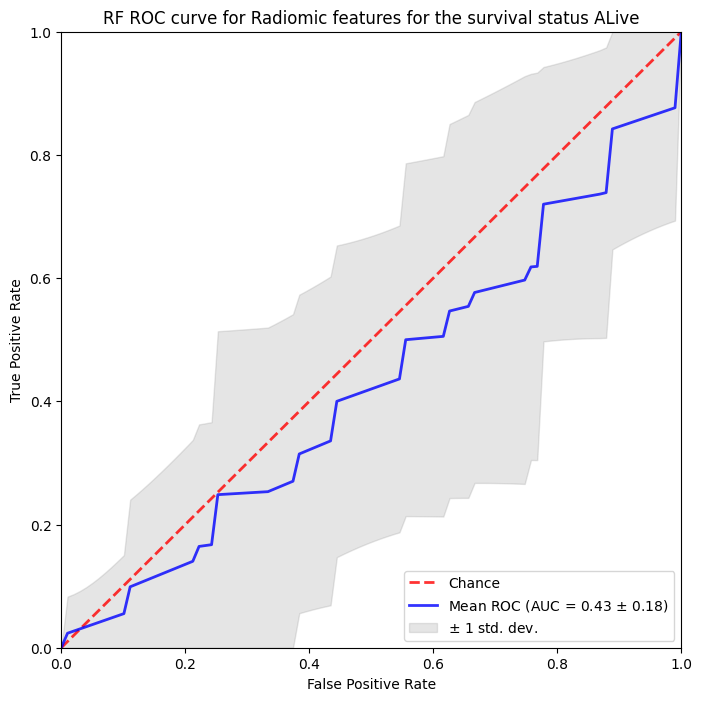

In [ ]:
i = 0
cv = StratifiedKFold(n_splits=10)
classifier = forest
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for train, test in cv.split(X_std_anova, y):
    probas_ = classifier.fit(X_std_anova[train], y[train]).predict_proba(X_std_anova[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC curve for Radiomic features for the survival status ALive')
plt.legend(loc="lower right" ,
           #fontsize = 'xx-small'
          )
#plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()

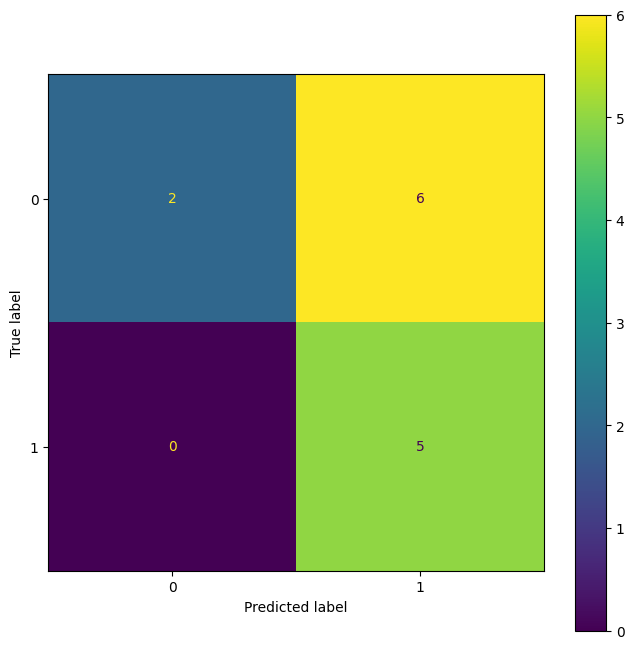

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_std_anova[test], y[test])